In [29]:
import numpy as np
import pandas as pd
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns

数据特征：
- 司机数量: 35449
- 订单数量: 181172
- GPS时间范围: 从 2016-11-01 00:02:02 到 2016-11-01 23:59:59
- 共有32155517条数据

In [30]:
df= pd.read_csv('filtered_orders.csv')
print(df.columns)

Index(['driver_id', 'order_id', 'gps_time', 'longitude', 'latitude',
       'time_diff'],
      dtype='object')


In [31]:
def haversine_vectorized(lon1, lat1, lon2, lat2, radius=6371000):
    """
    使用Numpy矢量化计算Haversine距离（单位：米）。
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = radius * c
    return distance


In [32]:
pd.options.display.float_format = '{:.5f}'.format
df['gps_time'] = pd.to_datetime(df['gps_time'])
df = df.sort_values(by=['order_id', 'gps_time'])

# 2. 优化的时间和距离间隔计算
df['time_diff'] = df.groupby('order_id')['gps_time'].diff().dt.total_seconds()
df[['prev_lon', 'prev_lat']] = df.groupby('order_id')[['longitude', 'latitude']].shift(1)
df['distance_diff'] = haversine_vectorized(
    df['prev_lon'], df['prev_lat'],
    df['longitude'], df['latitude']
)
df = df.drop(columns=['prev_lon', 'prev_lat'])

# 3. 统计分析
analysis_df = df.dropna(subset=['time_diff', 'distance_diff'])
print("\n--- 订单内连续GPS轨迹时间间隔分布分析 ---")
print(analysis_df['time_diff'].describe())
print("\n--- 订单内连续GPS轨迹点距离间隔分布分析 ---")
print(analysis_df['distance_diff'].describe())


--- 订单内连续GPS轨迹时间间隔分布分析 ---
count   333680.00000
mean         3.16209
std          0.80457
min          1.00000
25%          3.00000
50%          3.00000
75%          3.00000
max          9.00000
Name: time_diff, dtype: float64

--- 订单内连续GPS轨迹点距离间隔分布分析 ---
count   333680.00000
mean        28.68510
std         14.97624
min          0.95320
25%         18.12955
50%         27.87239
75%         37.80358
max         99.98854
Name: distance_diff, dtype: float64


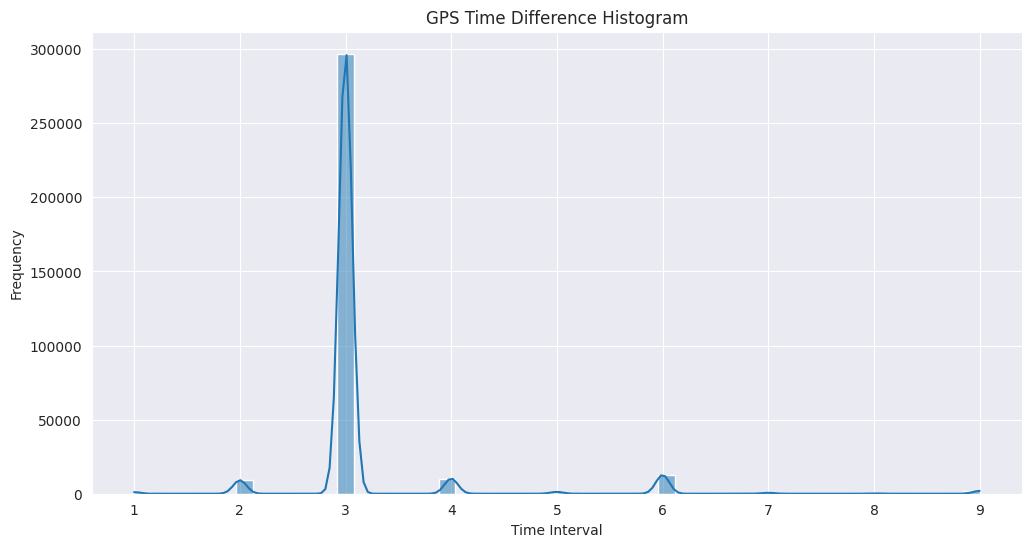

In [33]:
# 可视化时间间隔分布
plt.figure(figsize=(12, 6))
sns.histplot(analysis_df[analysis_df['time_diff'] <= 600]['time_diff'], bins=50, kde=True)
plt.title('GPS Time Difference Histogram')
plt.xlabel('Time Interval')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


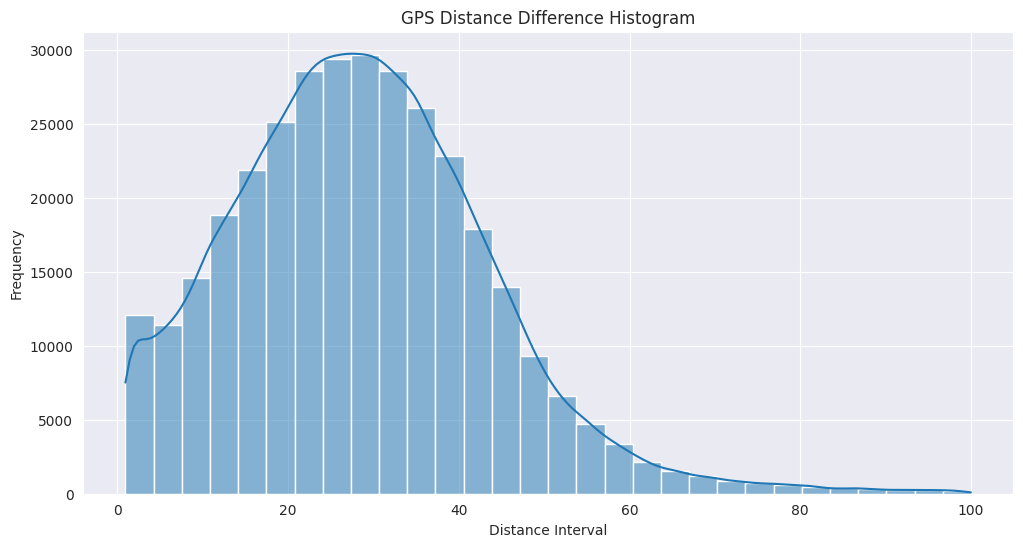

In [34]:
# 可视化距离间隔分布
plt.figure(figsize=(12, 6))
sns.histplot(analysis_df[analysis_df['distance_diff'] <= 2000]['distance_diff'], bins=30, kde=True)
plt.title('GPS Distance Difference Histogram')
plt.xlabel('Distance Interval')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()